# Project Overview

The goal of this project is to segment customers for TravelTide, an e-booking travel startup, in order to support the development of a personalized rewards program.

**Project Recap**

1. **Exploratory Data Analysis (EDA)**
 * Examined booking and session data to understand customer behavior.
 * Identified key patterns in travel type (hotel vs. flight), booking frequency, and average spend.

2. **Data Cleaning**
 * Handled missing values and outliers in variables such as `session_duration`.
 * Handled anomalies in de variables `rooms` and `nights`.

3. **Cohort Selection**
 * Included sessions older than 2023-01-04.
 * Included users with more than 6 sessions.

3. **Feature Engineering**
 * `age` and `age_group`
 * `engagement_level`
 * `spending_type`
 * `dream_traveler`
 * `travel_frequency`
 * `avg_days_between_booking`
 * `trip_type`
 * `trip_frequency_score`
 * `days_since_signup`
 * `sessions_per_week`
 * `avg_session_duration`
 * `pct_sessions_flight_discount_used` and `pct_sessions_hotel_discount_used`
 * `pct_sessions_flight_booked` and `pct_sessions_hotel_booked`
 * `cancel_rate`
 * `avg_days_between_trips`
 * `total_distance` and `avg_distance`
 * `total_price_paid` and `avg_price_paid`
 * `departure_flights`, `return_flights`, `total_flights`, and `pct_return_flights_booked`
 * `total_flight_cost`, `avg_flight_costs`, `avg_fligth_cost_before_discount`, and `avg_flight_discount`
 * `unique_cities_visited`
 * `total_hotel_cost`, `avg_hotel_cost`, `avg_hotel_spend_per_night`, `avg_hotel_cost_before_discount`, and `avg_hotel_disocunt`
 * `avg_checked_bags_per_trip`
 * `avg_nights_per_stay`
 * `avg_rooms_per_booking`

**Notebook Overview**

This notebook focuses on preprocessing and reducing the dimensionality of the data to prepare for clustering.

* Remove features that are hard to encode
* Check for missing values and duplicates
* Group uncommon home cities as 'other'
* Encode categorical features with One-Hot and Label encoding
* Normalize numerical features using StandardScaler
* Perform PCA to reduce the dimensionality of the data while keeping approximately 85% of the variance

# Libraries and Data

For this notebook we will upload the cleaned cohort selection.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv('/content/traveltide_cleaned_cohort_selection.csv')

# Cohort Summary

In [ ]:
print("Number of rows and columns:", df.shape)

Number of rows and columns: (5242, 54)


In [ ]:
# Create summary statistics
def summarize_metrics(dataframe):
    return {
        'total_users': df['user_id'].nunique(),
        'total_sessions': df['total_sessions'].sum(),
        'total_flights': df['total_flights'].sum(),
        'total_trips': df['total_trips'].sum(),
        'avg_session_duration': df['avg_session_duration'].mean(),
        'avg_page_clicks': df['total_page_clicks'].mean(),
        'avg_distance': df['avg_distance'].mean(),
        'avg_price_paid': df['avg_price_paid'].mean(),
        'avg_pct_flight_booked': dataframe['pct_sessions_flight_booked'].mean(),
        'avg_pct_hotel_booked': dataframe['pct_sessions_hotel_booked'].mean()
    }

cohort_summary = summarize_metrics(df)
summary_df = pd.DataFrame(cohort_summary, index=['summary']).T

# Display the summary table
display(summary_df.style.format("{:.2f}"))

,summary
total_users,5242.00
total_sessions,43019.00
total_flights,25304.00
total_trips,14895.00
avg_session_duration,185.66
avg_page_clicks,147.09
avg_distance,2224.01
avg_price_paid,1244.43
avg_pct_flight_booked,31.64
avg_pct_hotel_booked,33.07


# Preprocessing

In [ ]:
# Remove selected features
df.drop(columns=[
    'user_id',
    'departure_flights',
    'return_flights',
    'avg_flight_costs',
    'avg_flight_discount',
    'total_hotel_cost',
    'avg_hotel_cost',
    'avg_hotel_disocunt',
    'home_airport_lat',
    'home_airport_lon',
    'sessions_per_week',
    'first_trip_date',
    'last_trip_date',
    'dream_traveler'
], inplace=True)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.isnull().sum()

,0
age,0
age_group,0
engagement_level,0
spending_type,0
travel_frequency,0
avg_days_between_booking,0
trip_type,0
trip_frequency_score,0
days_since_signup,0
gender,0


In [ ]:
value_counts = df['home_city'].value_counts()
value_counts

,count
home_city,
new york,608
los angeles,273
toronto,202
chicago,180
houston,166
...,...
modesto,11
spokane,10
newport news,10


In [ ]:
common_cities = value_counts[value_counts > 25].index
df['home_city'] = df['home_city'].apply(lambda x: x if x in common_cities else 'Other')

In [ ]:
# Encode categorical features
# One-Hot Encoding
one_hot_columns = ['gender', 'age_group', 'married', 'has_children', 'home_country', 'spending_type', 'trip_type', 'travel_frequency']
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(df[one_hot_columns])

df_onehot = pd.DataFrame(one_hot_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out(), index=df.index)

# Label Encoding
label_columns = ['engagement_level', 'home_city', 'home_airport']
label_encoder = LabelEncoder()

for column in label_columns:
    df[column] = label_encoder.fit_transform(df[column])

df_label = df[label_columns]

# Adding DataFrame back together
df = pd.concat([df_onehot, df_label, df.drop(columns=one_hot_columns + label_columns)], axis=1)

In [ ]:
df

,gender_F,gender_M,gender_O,age_group_18-29,age_group_30-44,age_group_45-59,age_group_60+,married_False,married_True,has_children_False,...,total_flights,pct_return_flights_booked,total_flight_cost,avg_fligth_cost_before_discount,unique_cities_visited,avg_hotel_cost_before_discount,avg_checked_bags_per_trip,avg_nights_per_stay,avg_rooms_per_booking,avg_hotel_spend_per_night
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,4,100.0,864.09,0.000000,2,0.00,0.500000,1.000000,1.500000,76.666667
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,2,50.0,189.91,0.000000,1,0.00,0.000000,4.500000,1.500000,175.142857
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,10,100.0,1242.66,9.914000,5,0.00,0.400000,4.400000,1.000000,127.181818
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,6,60.0,2339.29,0.000000,3,55.14,1.000000,6.000000,1.250000,247.825000
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,6,100.0,1753.32,236.743333,3,0.00,0.666667,2.333333,1.333333,108.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,4,100.0,353.35,0.000000,2,0.00,0.000000,1.500000,1.000000,158.333333
5238,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,8,100.0,1039.17,0.000000,4,0.00,0.500000,5.000000,1.000000,36.000000
5239,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,4,100.0,721.52,0.000000,2,0.00,0.500000,4.500000,1.000000,183.888889
5240,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,6,100.0,409.96,48.660000,1,0.00,0.333333,2.333333,1.000000,154.428571


In [ ]:
# Scaling features
df_scaled = StandardScaler().fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [ ]:
df_scaled.describe(include='all')

,gender_F,gender_M,gender_O,age_group_18-29,age_group_30-44,age_group_45-59,age_group_60+,married_False,married_True,has_children_False,...,total_flights,pct_return_flights_booked,total_flight_cost,avg_fligth_cost_before_discount,unique_cities_visited,avg_hotel_cost_before_discount,avg_checked_bags_per_trip,avg_nights_per_stay,avg_rooms_per_booking,avg_hotel_spend_per_night
count,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,...,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03
mean,8.132881e-18,-4.608633e-17,1.016610e-17,1.152158e-17,2.710960e-18,1.355480e-17,-1.355480e-18,-1.050497e-16,1.050497e-16,6.099661e-18,...,-4.337537e-17,1.369035e-16,-6.235209e-17,-2.812621e-17,1.463919e-16,-2.778734e-17,-1.030165e-16,-1.789234e-16,-4.540859e-17,-2.019666e-16
std,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,...,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00
min,-2.786734e+00,-3.554475e-01,-4.371859e-02,-3.551070e-01,-8.817889e-01,-8.165615e-01,-2.307486e-01,-1.108059e+00,-9.024792e-01,-1.436560e+00,...,-1.709815e+00,-2.559850e+00,-1.084067e+00,-3.010313e-01,-1.732717e+00,-4.294488e-01,-1.151447e+00,-1.537078e+00,-3.030041e+00,-1.859090e+00
25%,3.588430e-01,-3.554475e-01,-4.371859e-02,-3.551070e-01,-8.817889e-01,-8.165615e-01,-2.307486e-01,-1.108059e+00,-9.024792e-01,-1.436560e+00,...,-1.001401e+00,-3.837369e-01,-6.343807e-01,-3.010313e-01,-9.756821e-01,-4.294488e-01,-1.151447e+00,-6.309291e-01,-4.559986e-01,-6.308167e-01
50%,3.588430e-01,-3.554475e-01,-4.371859e-02,-3.551070e-01,-8.817889e-01,-8.165615e-01,-2.307486e-01,9.024792e-01,-9.024792e-01,6.961072e-01,...,-2.929876e-01,7.043199e-01,-2.027599e-01,-3.010313e-01,-2.186475e-01,-4.294488e-01,-7.840664e-02,-2.080595e-01,-4.559986e-01,-1.812962e-01
75%,3.588430e-01,-3.554475e-01,-4.371859e-02,-3.551070e-01,1.134058e+00,1.224648e+00,-2.307486e-01,9.024792e-01,1.108059e+00,6.961072e-01,...,4.154261e-01,7.043199e-01,3.488992e-01,-6.240341e-02,5.383870e-01,6.125659e-02,9.946336e-01,2.752201e-01,4.020156e-01,4.066282e-01
max,3.588430e-01,2.813355e+00,2.287357e+01,2.816053e+00,1.134058e+00,1.224648e+00,4.333720e+00,9.024792e-01,1.108059e+00,6.961072e-01,...,3.957495e+00,7.043199e-01,1.339039e+01,3.732178e+01,3.566525e+00,1.369267e+01,9.578955e+00,9.336712e+00,7.266129e+00,9.667765e+00


# PCA Dimensionality Reduction

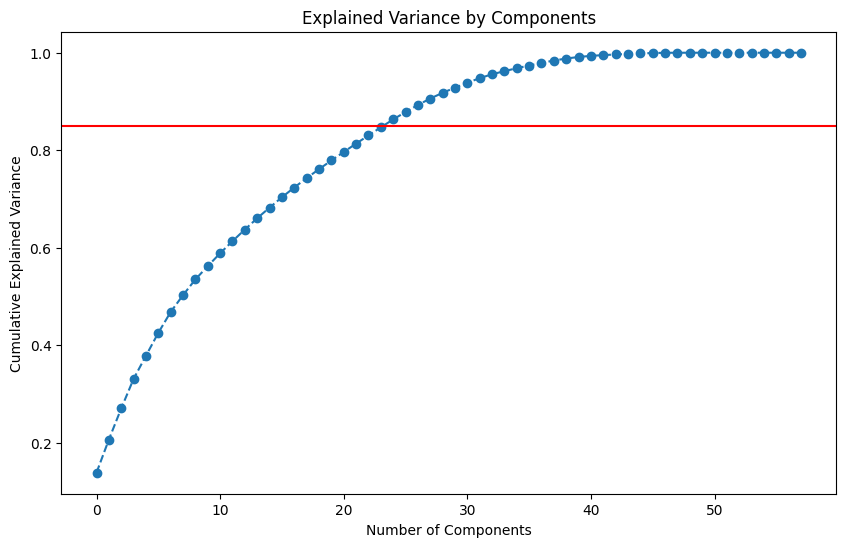

In [ ]:
pca = PCA()

pca.fit(df_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.axhline(y=0.85, color='r', linestyle='-', label='85% threshold')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

By the cumulative explained variance we can see that 24 components explain around 85% of the variance in the data.

In [ ]:
pca = PCA(n_components=24)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca)
df_pca.columns = [f"pca_{i}"for i in range(df_pca.shape[1])]
df_pca.index = df_scaled.index

print(f"Original number of features: {df_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {df_pca.shape[1]}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_):.5f}")

Original number of features: 58
Reduced number of features after PCA: 24
Cumulative explained variance: 0.84691


In [ ]:
df_pca = pd.DataFrame(df_pca)
df_pca.columns = [f"pca_{i}"for i in range(df_pca.shape[1])]
df_pca.index = df_scaled.index

In [ ]:
df_pca.to_csv("traveltide_cohort_prepocessed.csv", index=False)

In [ ]:
df_pca

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23
0,-0.996866,-1.866385,0.713815,-2.311458,-1.318030,-0.002187,0.562452,0.178158,1.184599,0.015706,...,0.245663,2.014010,-0.109203,-1.841826,-1.365881,-0.524226,-5.140203,6.004951,5.295017,-0.214393
1,-2.259742,-2.045579,2.537332,0.959736,1.156176,-0.742895,-1.106865,0.331832,1.000753,-0.644985,...,1.700958,0.806303,0.998025,-2.328880,0.365302,0.377112,-4.777379,5.721296,4.819797,-2.302982
2,4.312543,-1.212759,-0.731575,-1.220980,-1.400901,-1.376490,-1.233523,0.560206,-0.379219,2.338119,...,0.786808,0.911770,0.186356,-1.089798,0.762460,0.097798,-5.309739,6.260056,3.678553,-1.865340
3,3.042632,-0.721824,0.091233,2.719746,2.216856,-1.974262,-1.132384,0.423558,-0.882659,-1.375344,...,-1.177056,1.107761,0.793711,0.941969,0.140005,-0.115813,-5.299973,5.547812,4.350429,0.010375
4,0.954917,-0.669766,0.728935,-1.649718,-1.193814,-0.780791,2.645316,0.793646,0.599287,2.717014,...,1.241940,2.050489,0.258490,0.065587,-1.932898,-0.088939,-4.784398,5.370082,4.115287,-0.544100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,-1.437524,-1.140349,2.030335,-2.396620,0.306796,-0.993364,-0.972554,0.370895,1.408397,-0.472675,...,-0.985001,0.458910,0.425863,0.129854,-0.793649,-0.558796,1.078726,-1.476828,-1.493419,-0.719109
5238,1.577463,-1.076584,-1.199057,-2.253073,-1.077535,-0.074351,-0.469814,-0.028158,-0.724222,-1.563045,...,-0.694457,-0.185475,1.331458,1.184587,4.489634,4.294695,1.633281,-1.656835,0.835082,2.183955
5239,0.767145,1.320352,3.300528,-0.712934,-0.614715,4.279993,1.358911,0.382800,0.176084,-0.681927,...,-1.114123,-1.194473,-0.930251,0.786403,-0.911542,0.326884,2.071247,-2.400063,-0.382982,-0.312345
5240,-0.595409,-1.846170,1.559539,-1.751944,1.677797,3.437172,-1.638007,0.164156,1.378911,-1.237069,...,0.230938,-1.193651,0.486844,0.527888,0.172533,0.166459,1.752284,-1.722247,-1.790307,-0.683181


Now are data is ready to be used in Machine Learning Clustering Algorithms to segment the users.